# Notebook 04 - Feature Engineering

## Objectives

Engineer Features for:
* Classification
* Regression
* Clustering

## Inputs
* outputs/datasets/cleaned/test.csv

## Outputs
* Create Clean dataset:
    * all new datasets of cleaning will be stored in inputs/datasets/cleaning
* Split created dataset in to 3 parts:
    * Train
    * Validate
    * Test
* all new datasets (train, validate and test) will be stored in outputs/datasets/cleaned

## Change working directory
In This section we will get location of current directory and move one step up, to parent folder, so App will be accessing project folder.

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os

current_dir = os.getcwd()
current_dir

'/Users/pecukevicius/DataspellProjects/heritage_houses_p5/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chdir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("you have set a new current directory")

you have set a new current directory


Confirm new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/Users/pecukevicius/DataspellProjects/heritage_houses_p5'

## Loading Dataset

In [4]:
import pandas as pd

df = pd.read_parquet('outputs/datasets/cleaned/train.parquet.gzip')
df.head()

,Unnamed: 0,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
809,809,1075,1063,2,No,0,Unf,849,0,360,...,90,0,156,5,5,849,0,1898,1965,106000
608,608,1940,1254,4,Mn,428,BLQ,537,0,380,...,78,0,0,6,8,965,0,1934,1998,359100
1189,1189,1028,776,3,No,0,Unf,994,0,442,...,60,0,60,5,7,994,0,1999,1999,189000
1039,1039,630,0,1,Av,509,GLQ,121,0,286,...,21,0,0,4,4,630,0,1970,1970,80000
1297,1297,1072,0,2,Gd,547,GLQ,0,0,525,...,35,82,44,5,6,547,0,2005,2006,140000


## Data Exploration
After FIASKO with Hypothesis 1, we need to explore all features.

Issues: we have so many features to explore, what will be Hard to check, with all transformation.

Goal: 
1. Encode all Categorical features with Ordinal Encoder
2. Now all Features are numerical, so we will transform all of them with all numerical transformations
3. Create functionality:
* Filter all new transformed features by original name
* In loop keep dropping new created features - transformations with not good parameters:
    * Skewness
    * Kurtosis
    * Check if Correlation has changed to SalePrice and other features

## Feature Engineering

Functions for encoding, Plot functionality is removed to speed up process

In [5]:
%matplotlib inline

import seaborn as sns
import pandas as pd
import warnings
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer

sns.set(style="whitegrid")
warnings.filterwarnings('ignore')


def FeatureEngineeringAnalysis(df, analysis_type=None):
    """
    - used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape
    - Once transformed, use a reporting tool, like ydata-profiling, to evaluate distributions
    """
    check_missing_values(df)
    allowed_types = ['numerical', 'ordinal_encoder', 'outlier_winsorizer']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop in each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

        # Apply transformers in respective column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(
            analysis_type, df_feat_eng, column)

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """ Check analysis type """
    if analysis_type is None:
        raise SystemExit(
            f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            f"There is a missing value in your dataset. Please handle that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
    """ Set suffix columns according to analysis_type"""
    if analysis_type == 'numerical':
        list_column_transformers = [
            "log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]

    elif analysis_type == 'ordinal_encoder':
        list_column_transformers = ["ordinal_encoder"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr']

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column):
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')

    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(
            df_feat_eng, column)

    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(
            df_feat_eng, column)

    elif analysis_type == 'ordinal_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(
            df_feat_eng, column)

    return df_feat_eng, list_applied_transformers


def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    list_methods_worked = []
    try:
        encoder = OrdinalEncoder(encoding_method='arbitrary', variables=[
            f"{column}_ordinal_encoder"])
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_ordinal_encoder")

    except Exception:
        df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    # Winsorizer iqr
    try:
        disc = Winsorizer(
            capping_method='iqr', tail='both', fold=1.5, variables=[f"{column}_iqr"])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_iqr")
    except Exception:
        df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_Numerical(df_feat_eng, column):
    list_methods_worked = []

    # LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except Exception:
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

    # LogTransformer base 10
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_10"], base='10')
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except Exception:
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    # ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except Exception:
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

    # PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except Exception:
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

    # BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except Exception:
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

    # YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except Exception:
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked

Getting List of Categorical Features

In [6]:
categorical_features = df.select_dtypes(['object', 'category']).columns.tolist()
categorical_features

['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']

## Transformations

Categorical Encoding

Checking if all columns are like from Original Dataset, if there is extra ones, we will drop them

In [7]:
feat_compare = pd.read_csv('outputs/datasets/collection/HousePricesRecords.csv').columns.tolist()
df = df[feat_compare]

In [8]:
df.columns

Index(['Unnamed: 0', '1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtExposure',
       'BsmtFinSF1', 'BsmtFinType1', 'BsmtUnfSF', 'EnclosedPorch',
       'GarageArea', 'GarageFinish', 'GarageYrBlt', 'GrLivArea', 'KitchenQual',
       'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'OverallCond',
       'OverallQual', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd',
       'SalePrice'],
      dtype='object')

This is funny, what is that Unnamed: 0? let's check

In [9]:
df['Unnamed: 0']

809      809
608      608
1189    1189
1039    1039
1297    1297
        ... 
866      866
742      742
74        74
176      176
338      338
Name: Unnamed: 0, Length: 1168, dtype: int64

Looks like a copy of Index. Yeah… CSV, as I mentioned in README.md - Noot good for storing, you either loose data or get too many :D
Lets drop it

In [10]:
df = df.drop(columns=['Unnamed: 0'])
orig_feat = df.columns.tolist()
orig_feat
import pandas as pd
import warnings
from feature_engine.encoding import OrdinalEncoder

warnings.filterwarnings('ignore')


def encode_categorical_features(df):
    """
    Encodes only the categorical features in the DataFrame while leaving other features unchanged.
    Assumes that categorical features are of type 'category' or 'object'.
    """
    # Identify categorical columns in the DataFrame
    categorical_cols = df.select_dtypes(include=['category', 'object']).columns.tolist()

    # Apply ordinal encoding only to categorical columns
    if categorical_cols:
        encoder = OrdinalEncoder(encoding_method='arbitrary', variables=categorical_cols)
        df = encoder.fit_transform(df)

    return df


df[categorical_features] = encode_categorical_features(df)[categorical_features]

In [11]:
df = FeatureEngineeringAnalysis(df=df, analysis_type='numerical')

### Generating Ydata Report

As in previous Hypothesis, i will create YdataProfiling report as an external File.
It will be huge, so i will save it as an external file: outputs/reports/hypothesis_1_transformations_ydata_report.html

In [12]:
from ydata_profiling import ProfileReport

hypothesis_2_transformations_profile = ProfileReport(df=df, minimal=True)
hypothesis_2_transformations_profile.to_file('outputs/reports/hypothesis_2_transformations_ydata_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Transformations Summary

From exloring all transformations I have these conclusions (based on skew, kurtosis):

1. 1stFlrSF - Yeo Johnson,  Log10, no furthers preprocessing needed
2. 2ndFlrSF -  Yeo Johnson, Power, no furthers preprocessing needed, lots of 0 values
3. BedroomAbvGr - Yeo Johnson, Box Cox, Power, no furthers preprocessing needed
4. BsmtExposure - Yeo Johnson, no furthers preprocessing needed, lots of 0 values
5. BsmtFinSF1 - Yeo Johnson, Power, on Power might need scaling
6. BsmtFinType1 - Yeo Johnson, Power, no furthers preprocessing needed
7. BsmtUnfSF - Yeo Johnson, Power, might need scaling
8. EnclosedPorch - Power, might need scaling, 98% are 0 values
9. GarageArea - Original Values, will need scaling
10. GarageFinish - Yeo Johnson, Power, no furthers preprocessing needed, 48% are 0 values
11. GarageYrBlt - Log_10, as other transformations , as Yeo Johnson and Box Cox introduced extremely high values with e87
12. GrLivArea - Log_e, Log_10, Yeo Johnson, no furthers preprocessing needed
13. KithenQual - Power, no furthers preprocessing needed, 51% has 0 values
14. LotArea - Log_10, Box_Cox, Yeo  Johnson, no furthers preprocessing needed
15. LotFrontage - Box_Cox, Yeo Johnson, might need scaling on both
16. MasVnrArea - Yeo Johnson, no furthers preprocessing needed, 59% has 0 values
17. OpenPorchSF - Yeo Johnson, no furthers preprocessing needed, 46% are 0 values
18. OverallCond - Yeo Johnson, no furthers preprocessing needed
19. OverallQual - Power, no furthers preprocessing needed
20. TotalBsmtSF - Yeo Johnson, might need scaling, high numbers. will see in model
21. WoodDeckSF - Yeo Johnson, a lot of 0 values, 94% 0 values, no furthers preprocessing needed
22. YearBuilt - Log_10, as other transformations , as Yeo Johnson and Box Cox introduced extremely high values with e70
23. YearRemodAdd - Log10, no furthers preprocessing needed
24. SalePrice - Yeo Johnson, Log_10, no furthers preprocessing needed

### Plotting Selected Transformations, to see outliers

First Lets Make a list of transformations we want to explore, instead of lots of writing, i will reuse code i made in Previous Feature Engineering

Plotting selected transformations to see Outliers

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def plot_histogram_and_boxplot(df):
    for col in df.columns:
        # Create the figure and axes
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 7), gridspec_kw={"height_ratios": (.15, .85)})

        # Plotting the boxplot
        sns.boxplot(data=df, x=col, ax=axes[0])

        # Plotting the histogram with KDE
        sns.histplot(data=df, x=col, kde=True, ax=axes[1])

        # Setting the main title for the figure
        fig.suptitle(f"{col} Distribution - Boxplot and Histogram")

        # Calculating IQR
        IQR = df[col].quantile(q=0.75) - df[col].quantile(q=0.25)
        outlier_range_min = (df[col].quantile(q=0.25) - 1.5 * IQR).round(2)
        outlier_range_max = (df[col].quantile(q=0.75) + 1.5 * IQR).round(2)

        # Calculating skewness and kurtosis
        skewness = df[col].skew().round(2)
        kurtosis = df[col].kurt().round(2)

        # Annotation string
        stats_text = (
            f"Skewness: {skewness}\n"
            f"Kurtosis: {kurtosis}\n"
            f"IQR: {IQR.round(2)}\n"
            f"Non-outlier range: [{outlier_range_min}, {outlier_range_max}]"
        )

        # Place the text box on the histogram plot
        axes[1].text(0.95, 0.95, stats_text, transform=axes[1].transAxes, verticalalignment='top',
                     horizontalalignment='right', fontsize=10, bbox=dict(boxstyle="round,pad=0.5",
                                                                         facecolor='white', edgecolor='gray',
                                                                         alpha=0.9))

        # Display the plot
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

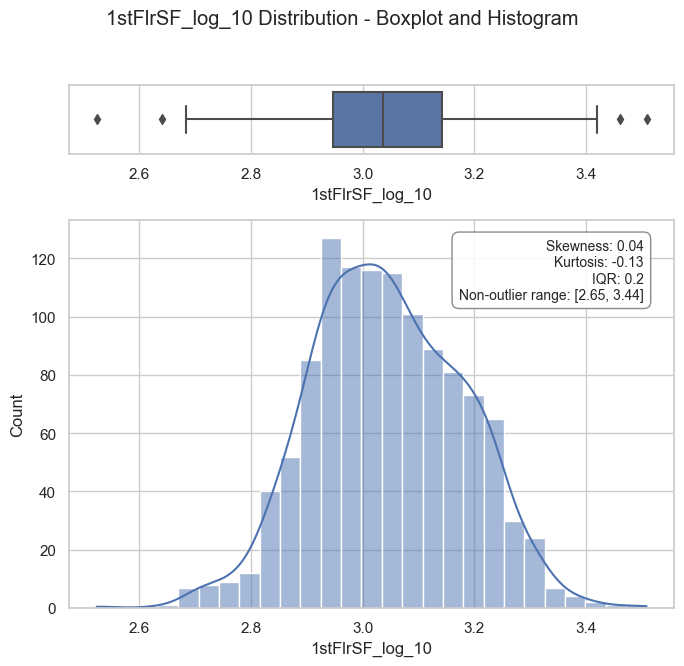

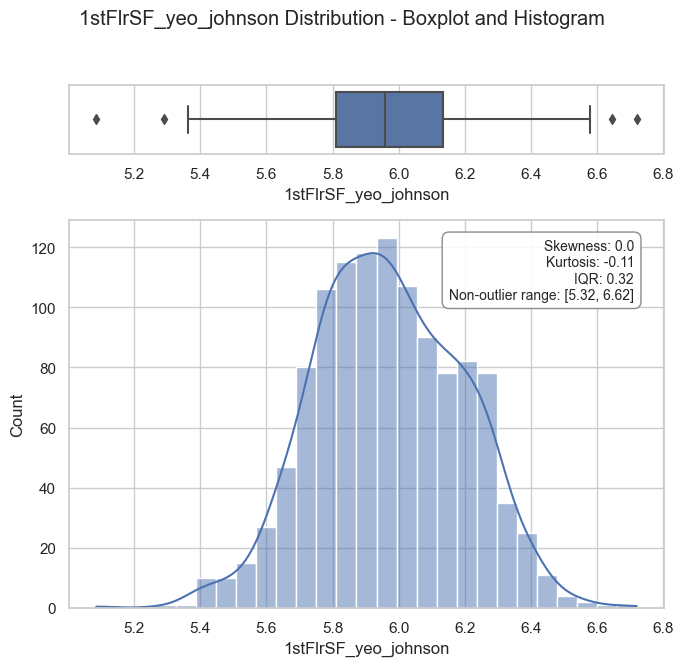

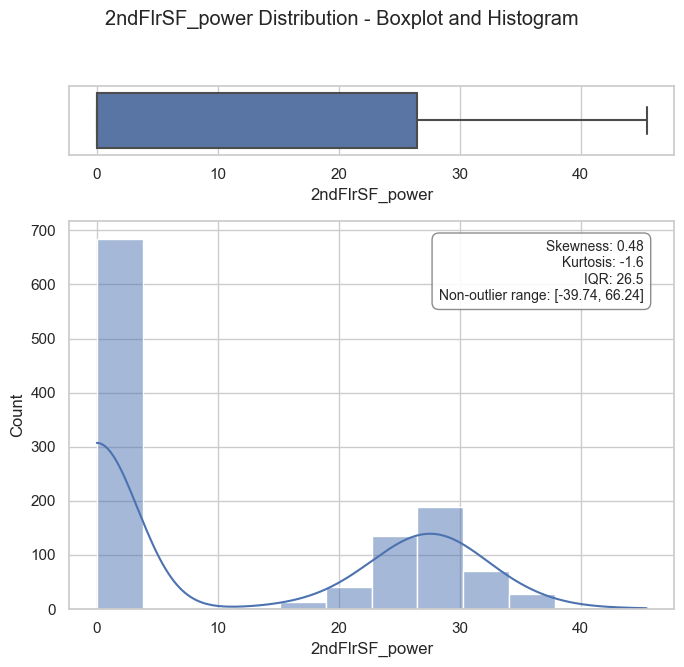

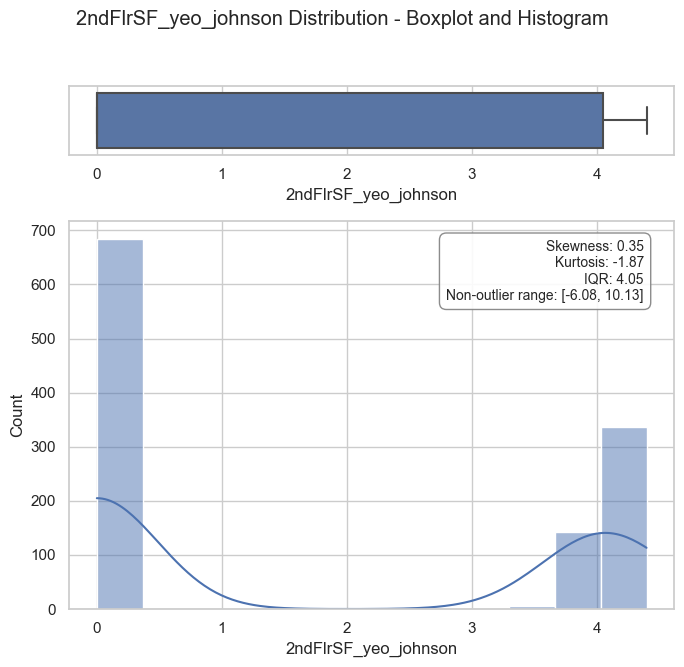

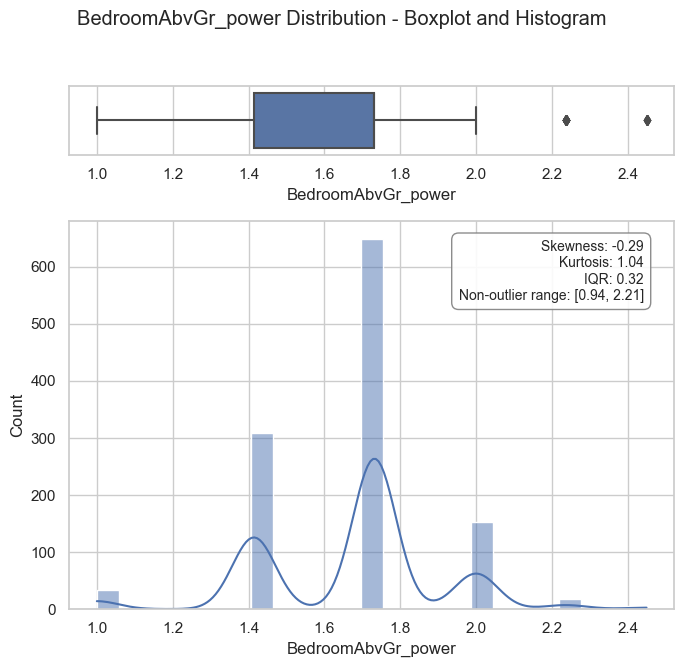

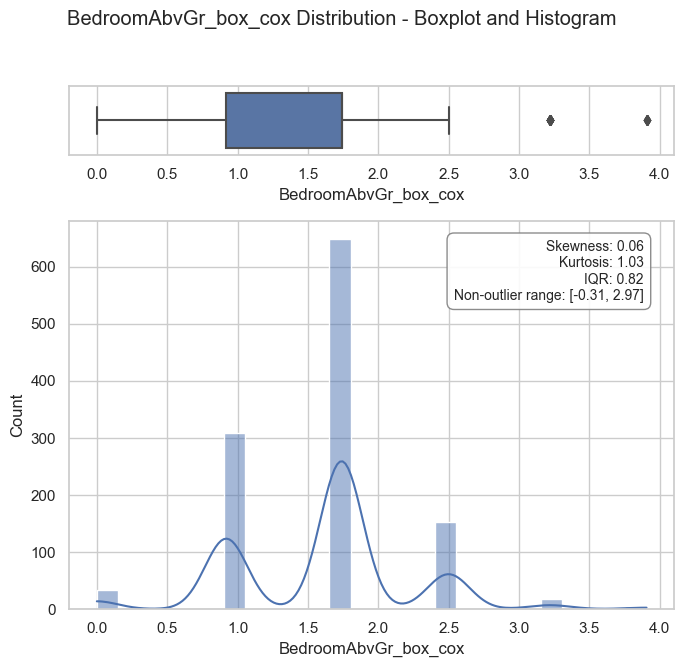

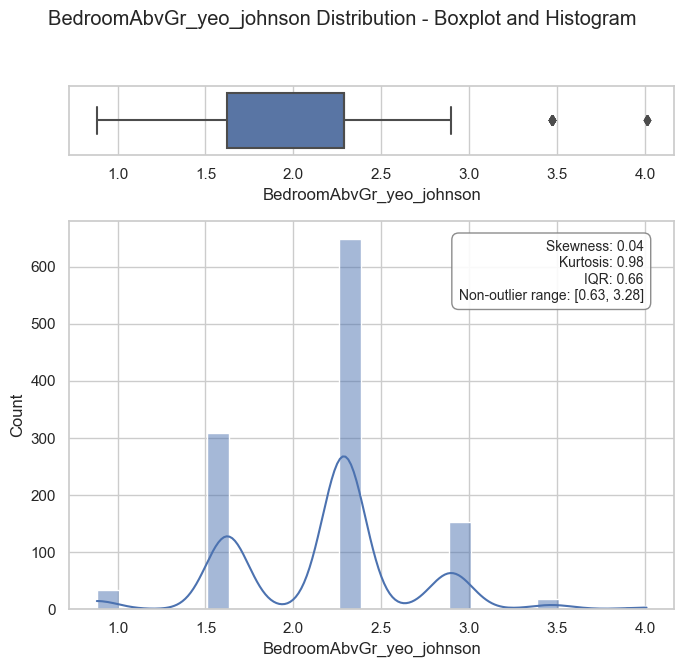

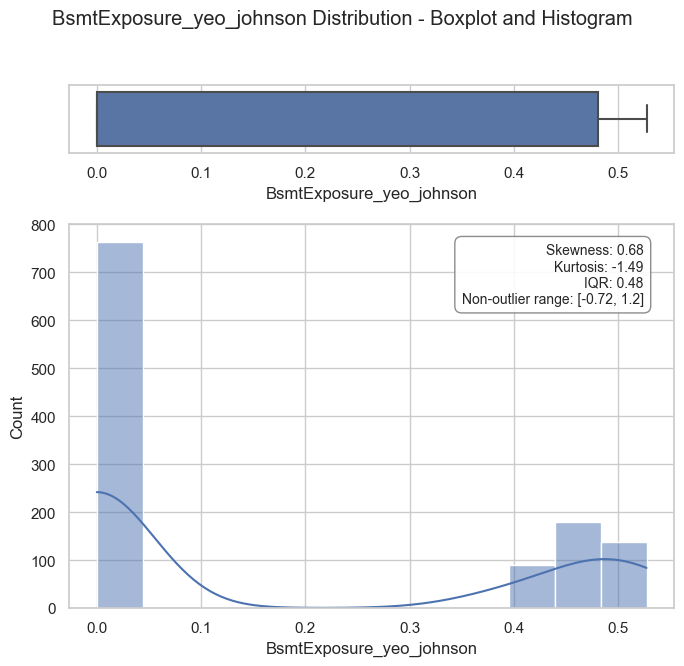

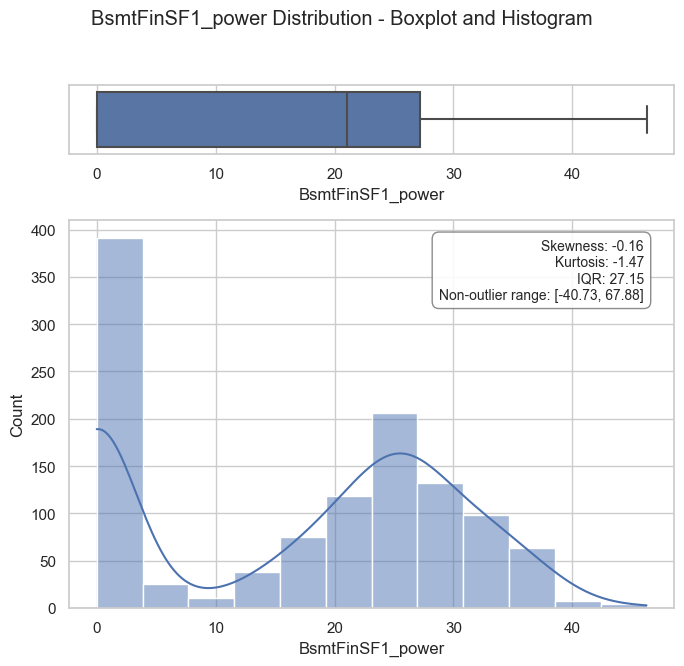

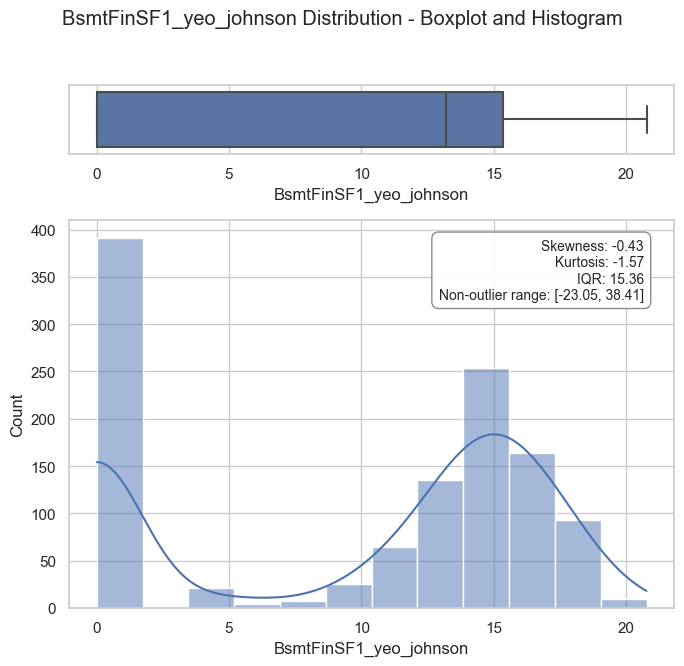

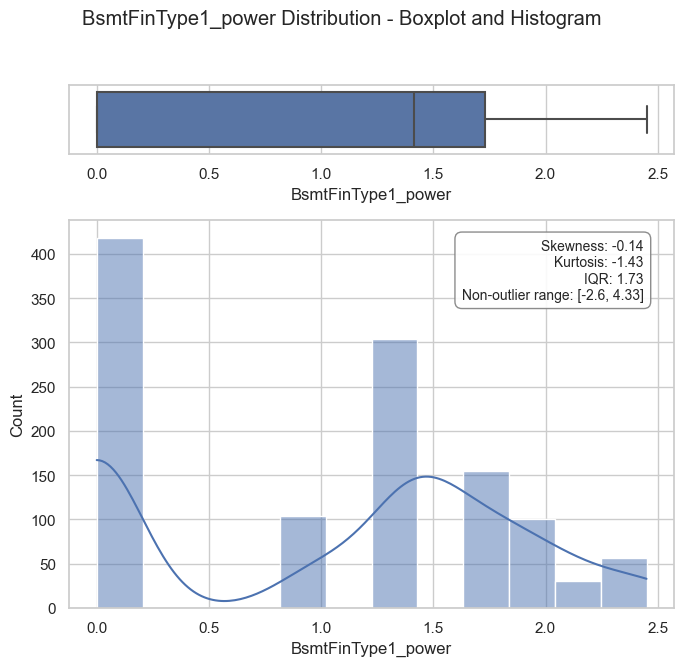

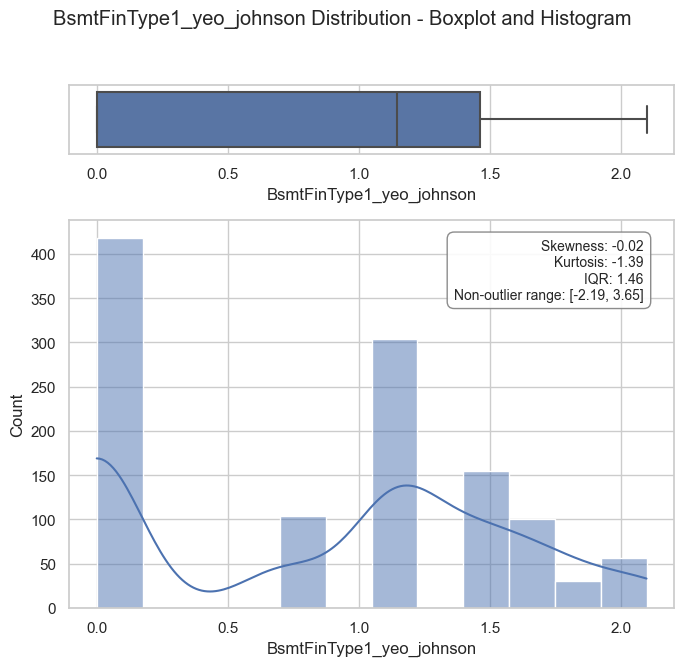

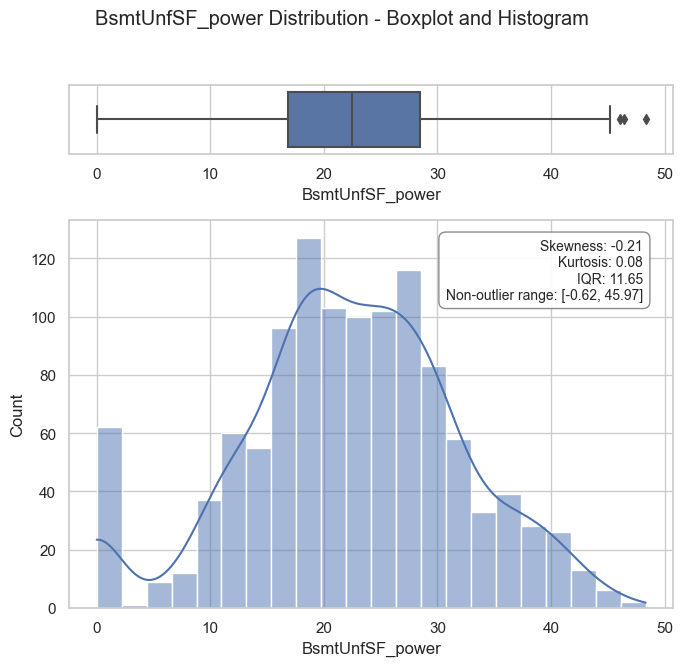

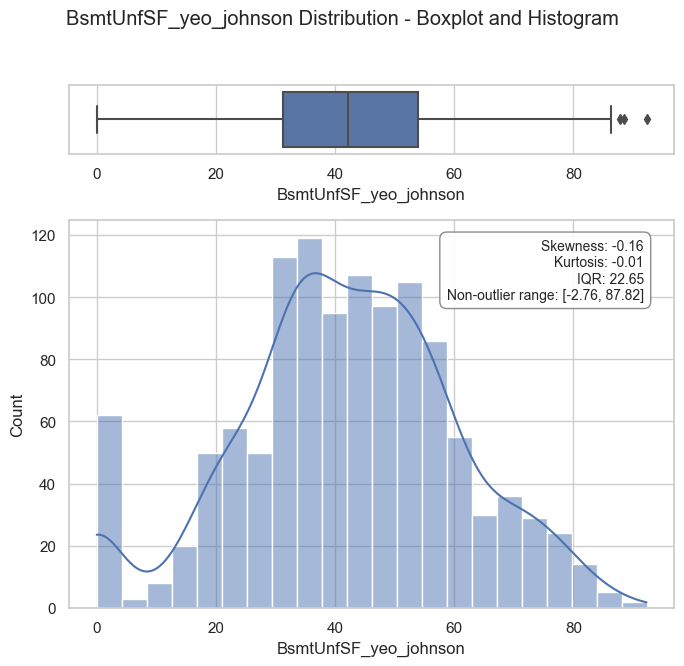

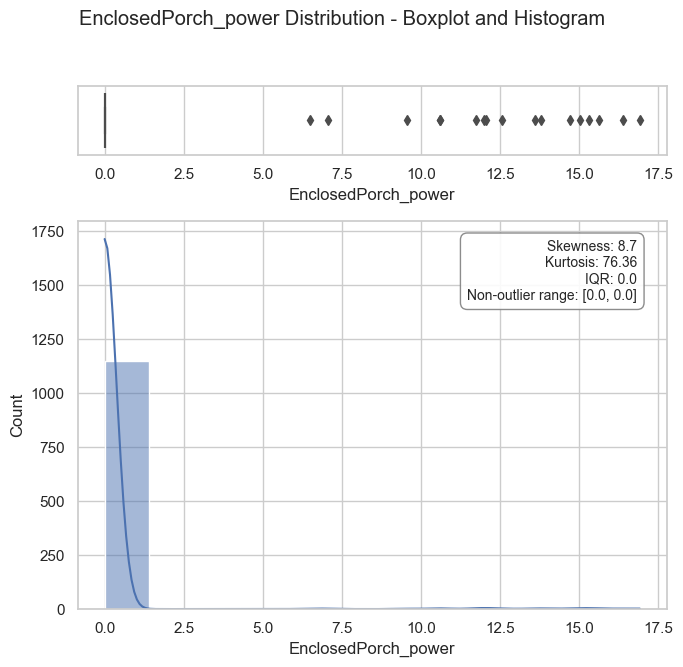

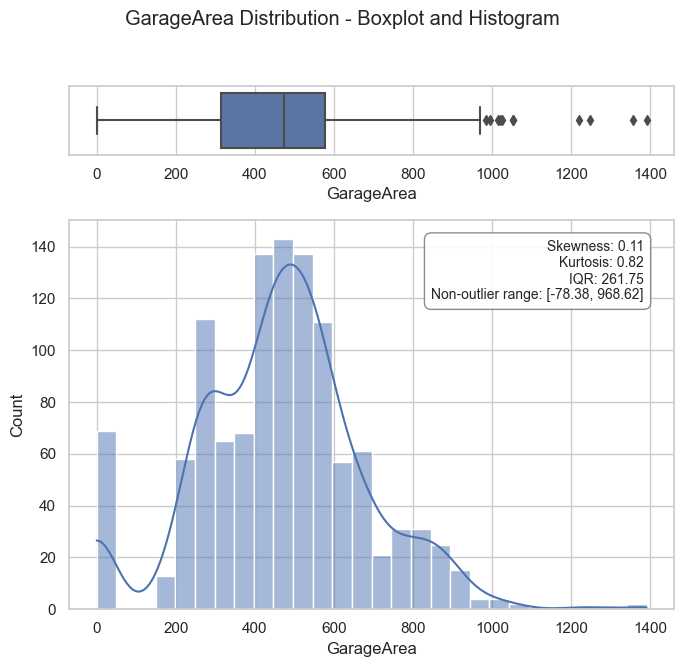

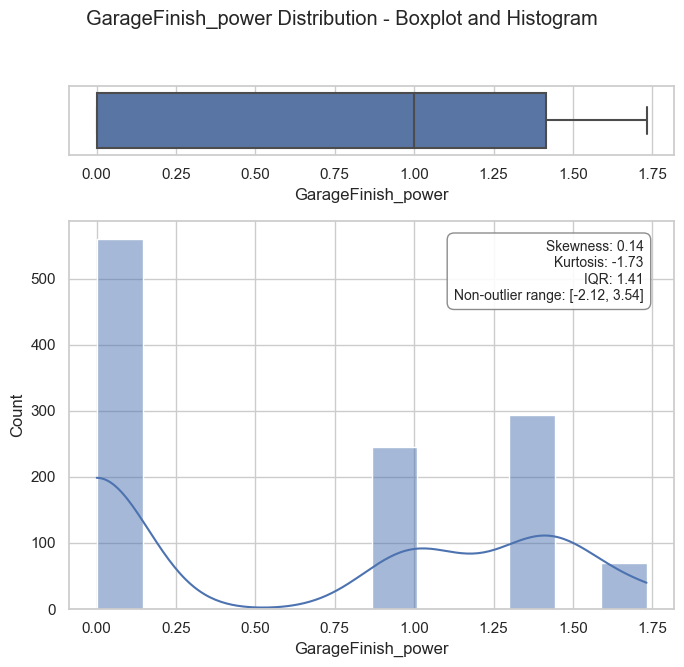

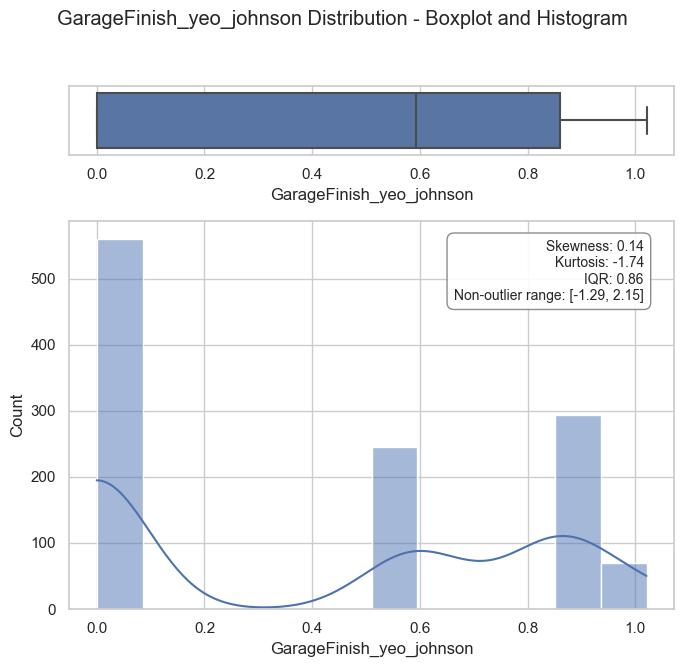

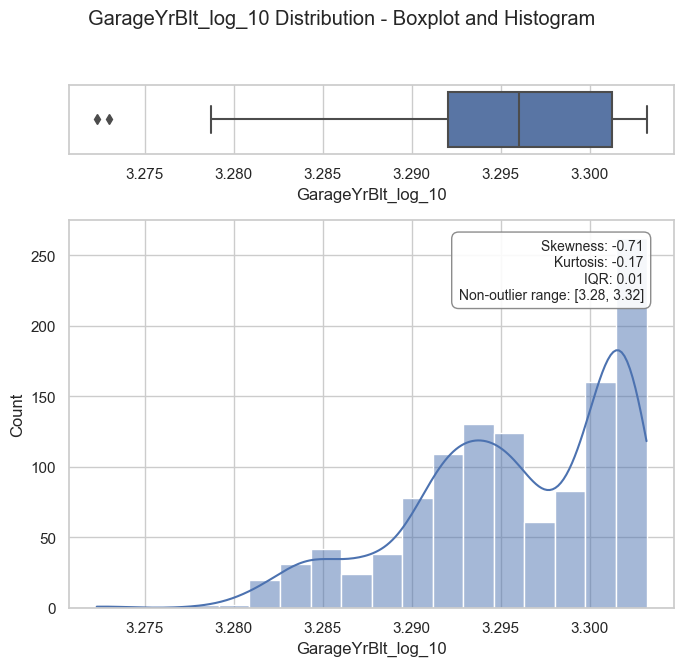

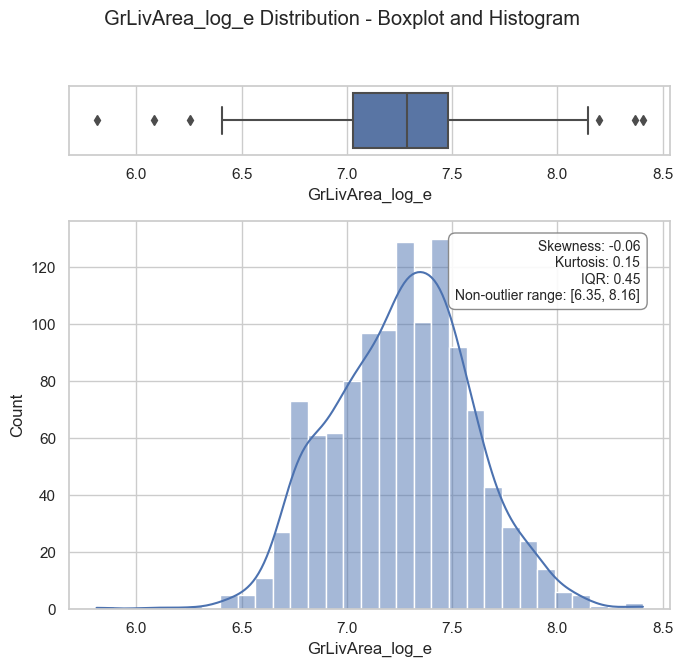

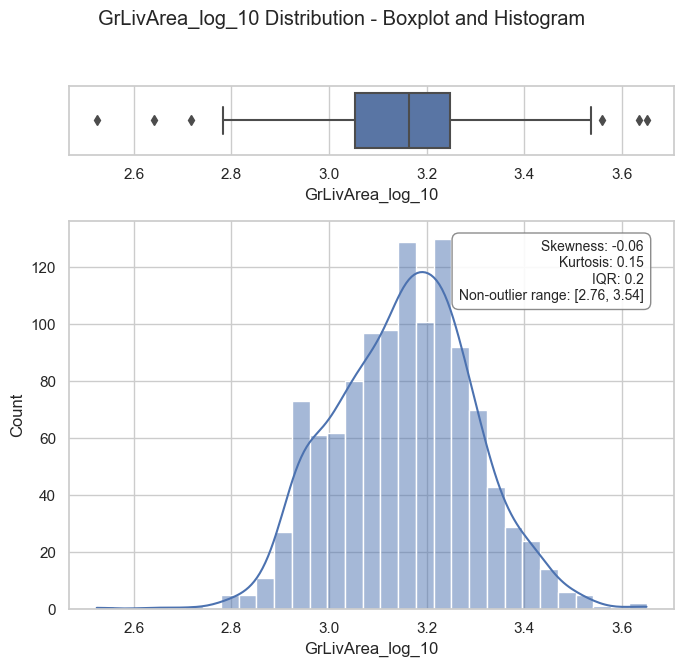

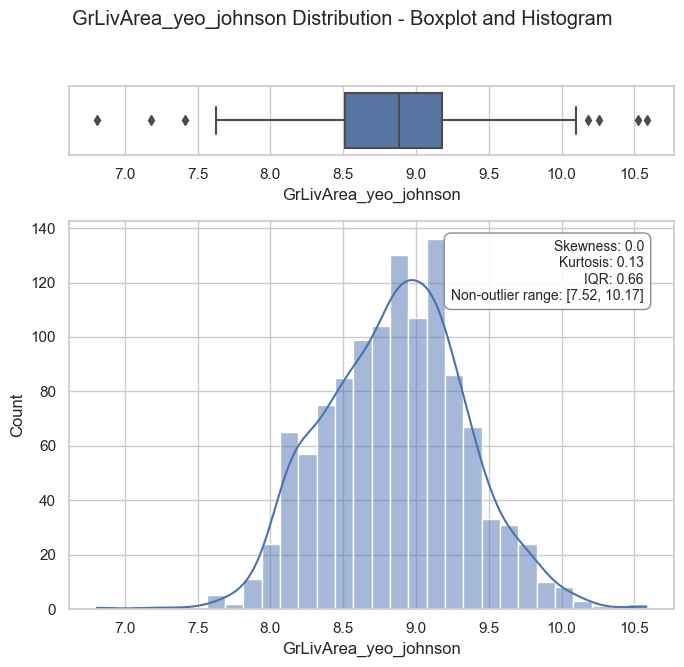

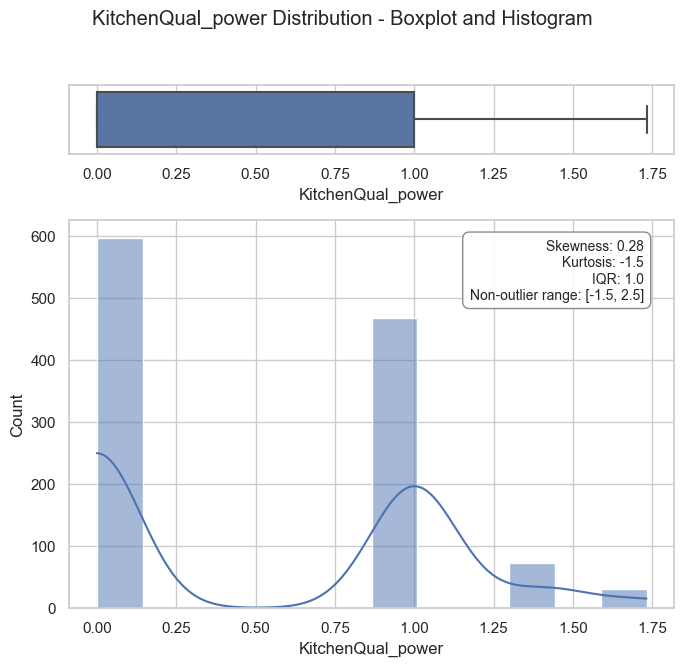

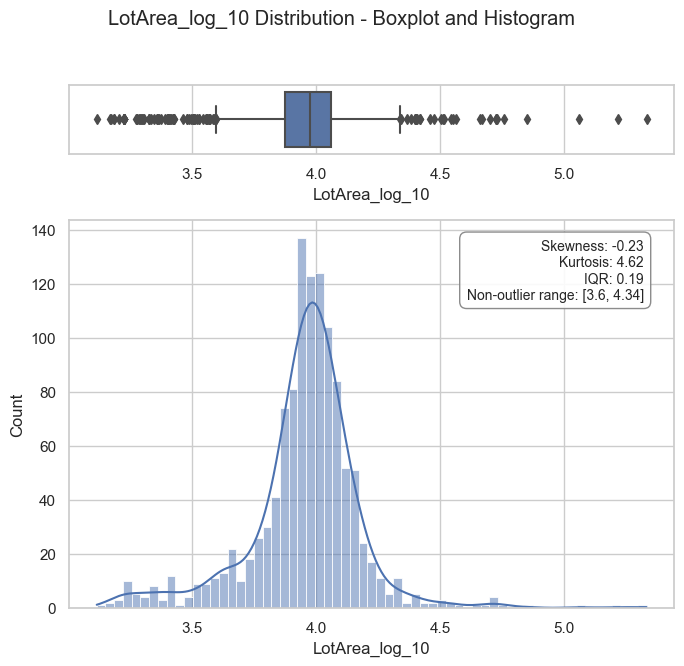

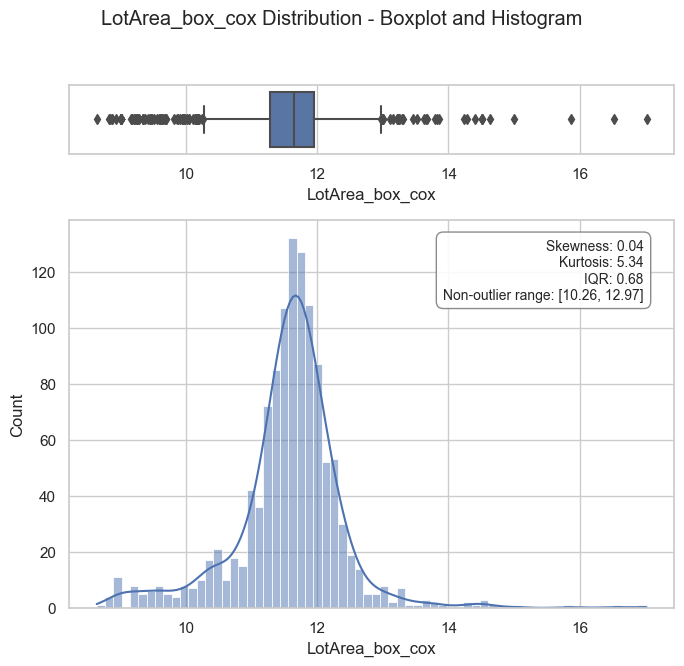

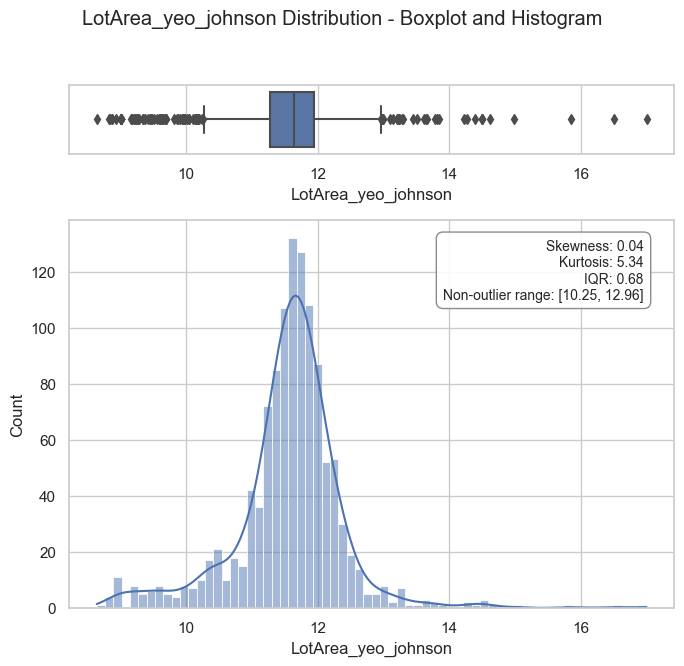

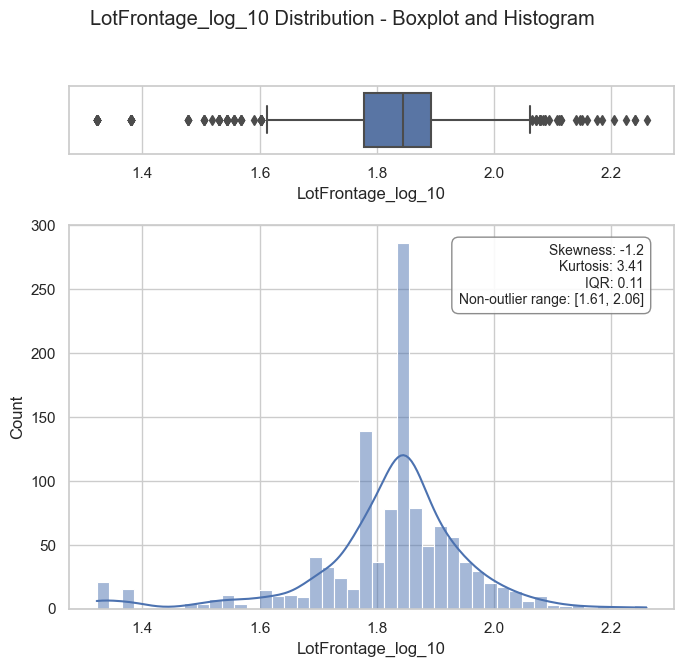

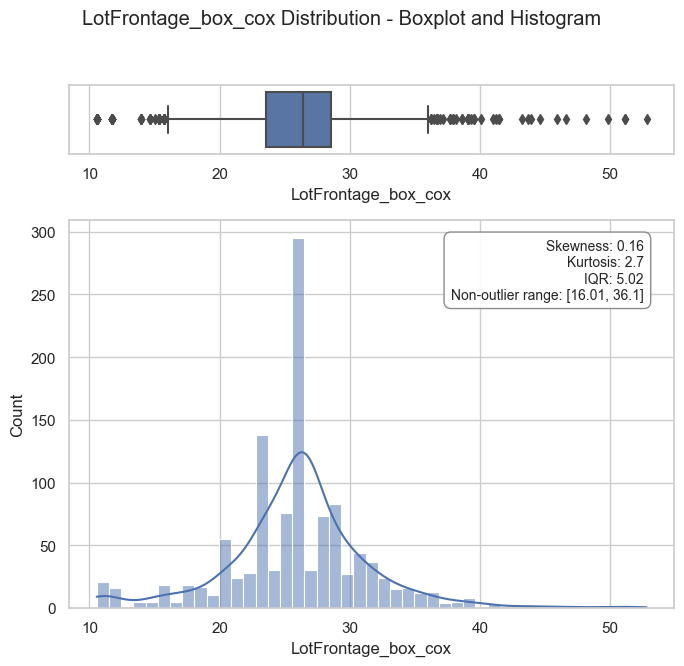

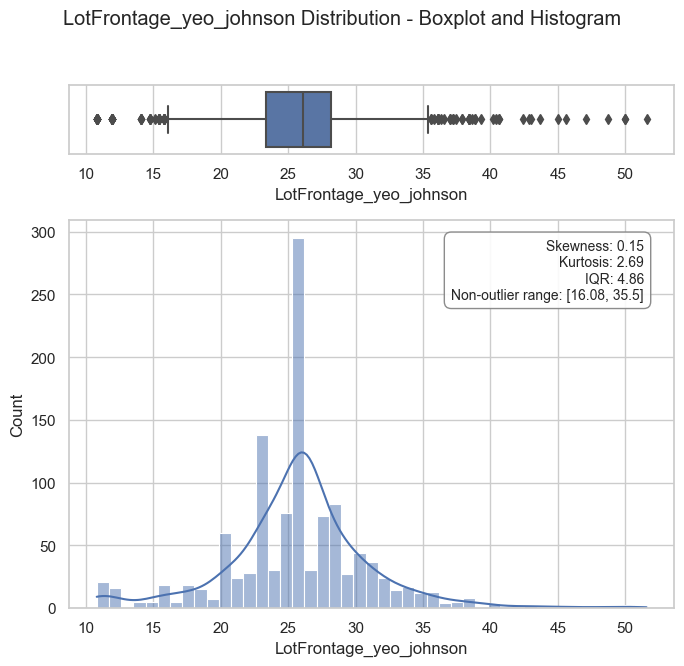

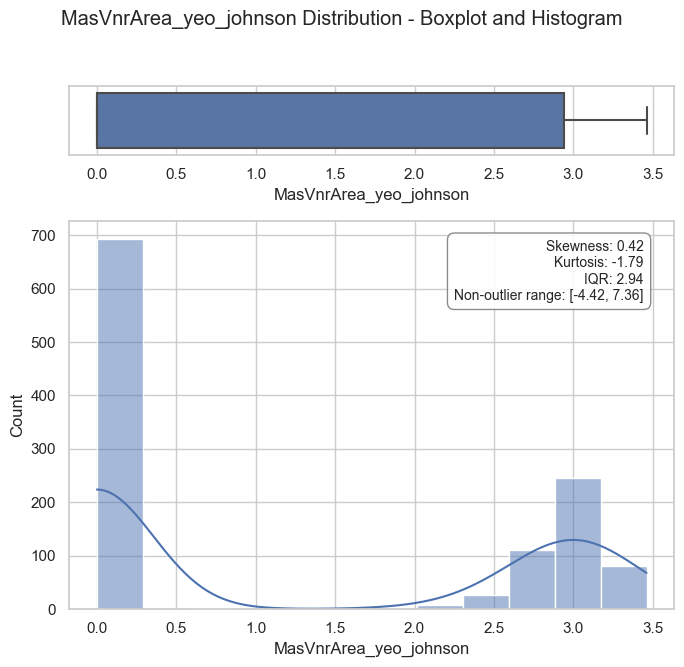

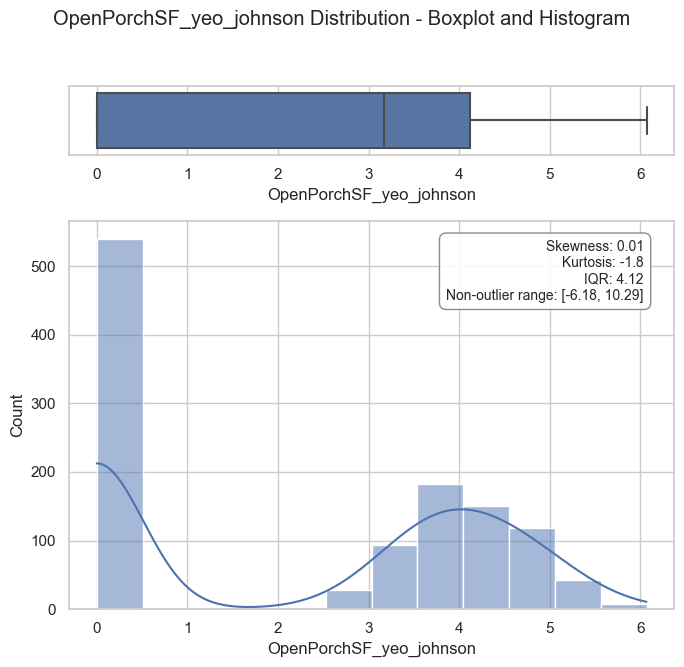

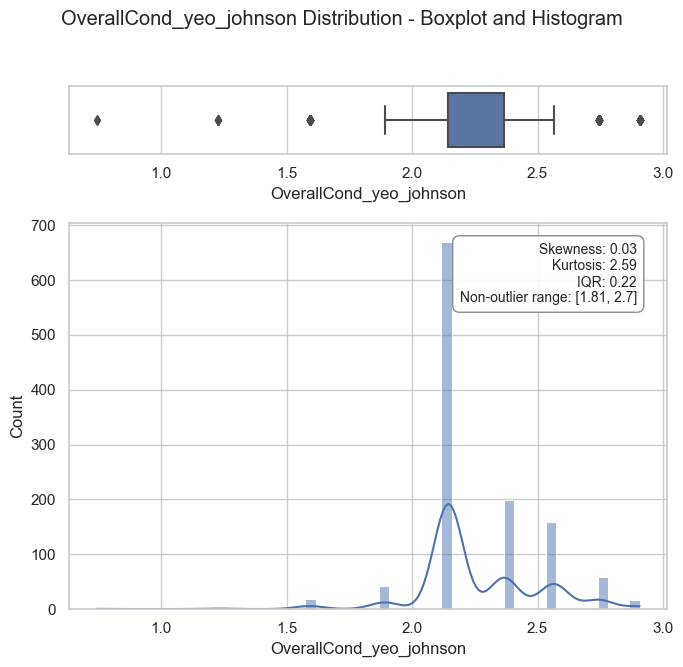

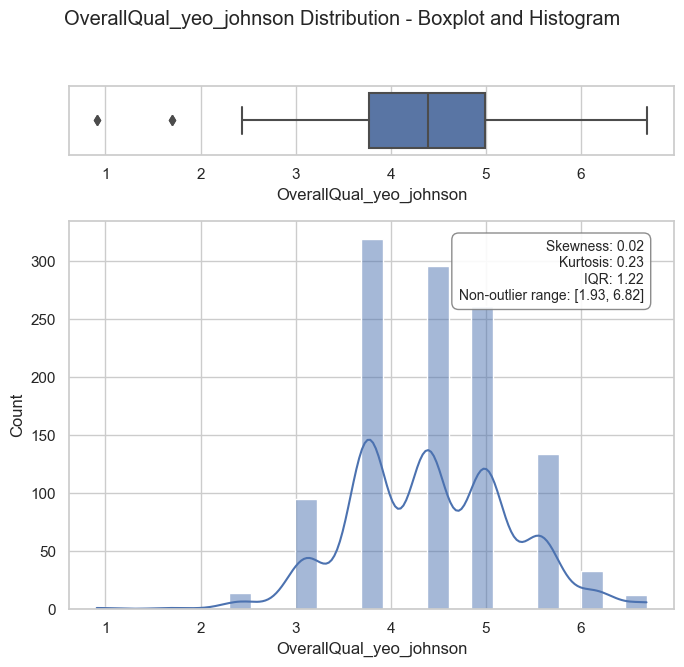

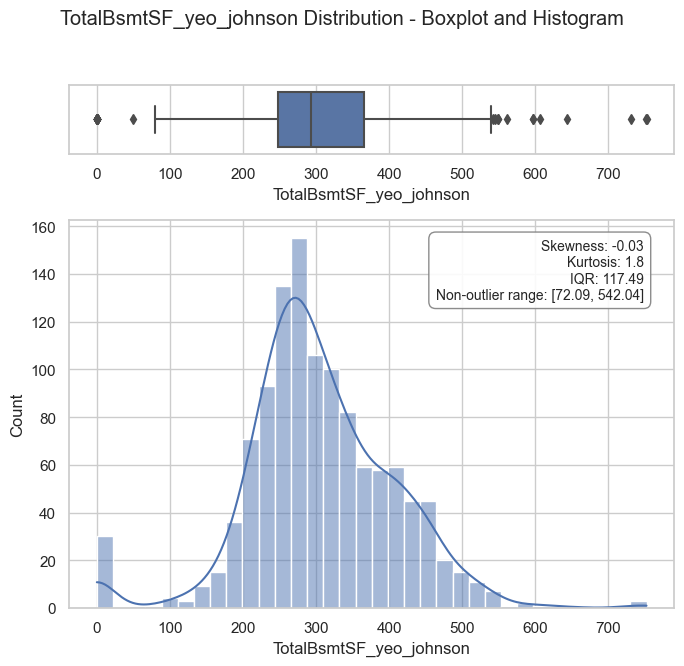

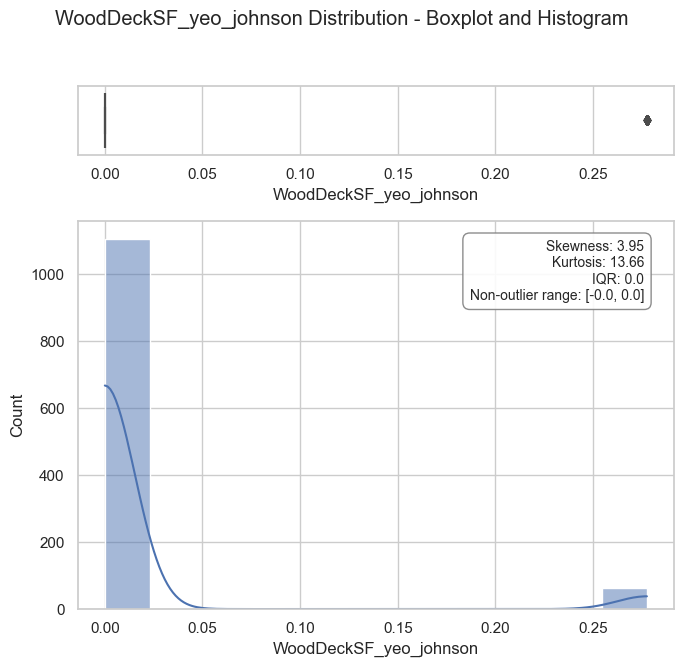

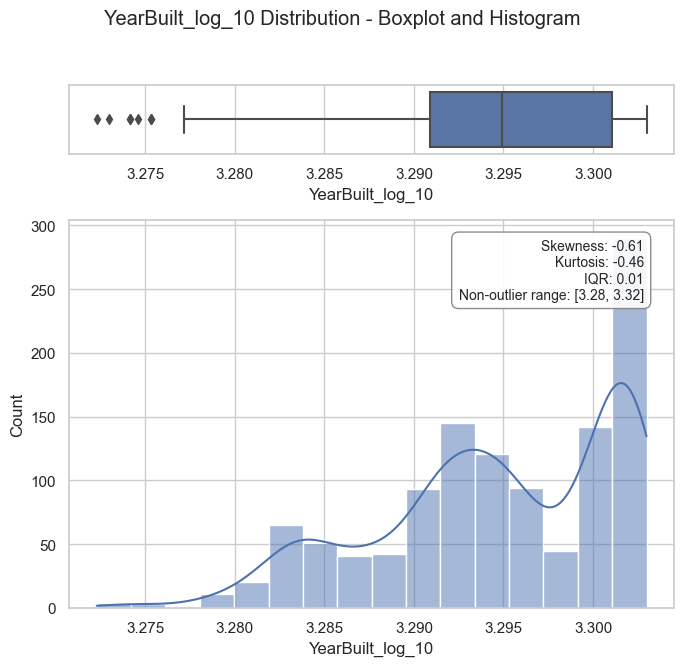

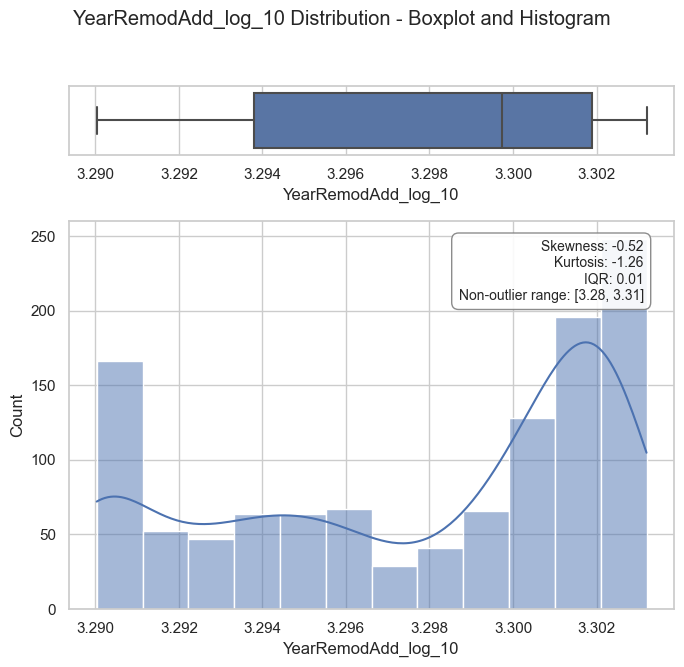

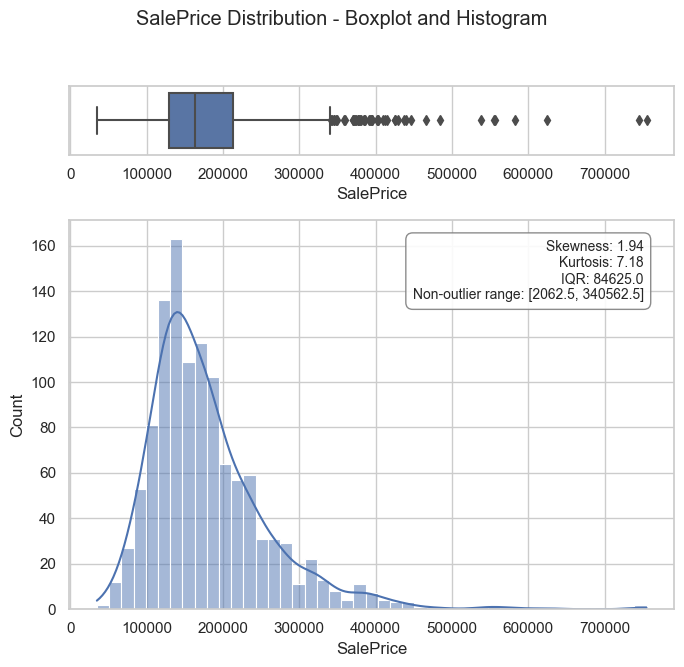

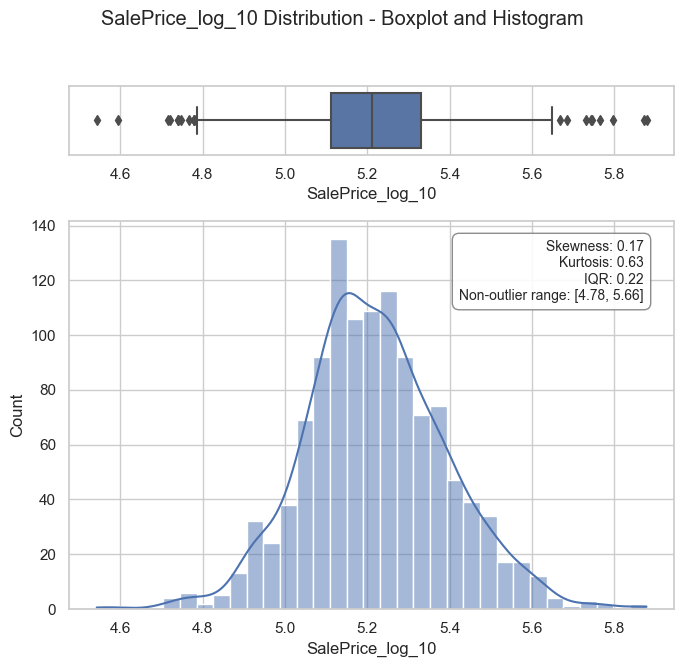

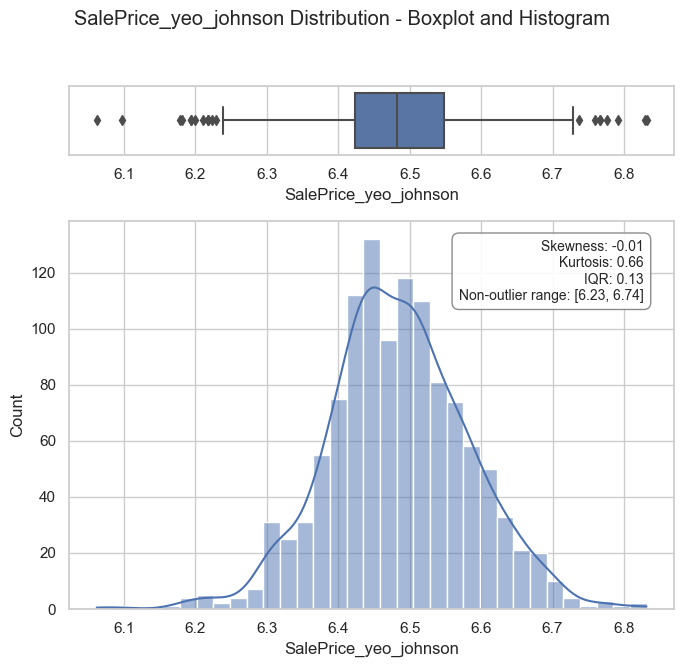

In [14]:
plot_histogram_and_boxplot(df[['1stFlrSF_log_10', '1stFlrSF_yeo_johnson', '2ndFlrSF_power', '2ndFlrSF_yeo_johnson',
                               'BedroomAbvGr_power', 'BedroomAbvGr_box_cox', 'BedroomAbvGr_yeo_johnson',
                               'BsmtExposure_yeo_johnson', 'BsmtFinSF1_power', 'BsmtFinSF1_yeo_johnson',
                               'BsmtFinType1_power', 'BsmtFinType1_yeo_johnson', 'BsmtUnfSF_power',
                               'BsmtUnfSF_yeo_johnson', 'EnclosedPorch_power', 'GarageArea', 'GarageFinish_power',
                               'GarageFinish_yeo_johnson', 'GarageYrBlt_log_10', 'GrLivArea_log_e', 'GrLivArea_log_10',
                               'GrLivArea_yeo_johnson', 'KitchenQual_power', 'LotArea_log_10', 'LotArea_box_cox',
                               'LotArea_yeo_johnson', 'LotFrontage_log_10', 'LotFrontage_box_cox',
                               'LotFrontage_yeo_johnson', 'MasVnrArea_yeo_johnson', 'OpenPorchSF_yeo_johnson',
                               'OverallCond_yeo_johnson', 'OverallQual_yeo_johnson', 'TotalBsmtSF_yeo_johnson',
                               'WoodDeckSF_yeo_johnson', 'YearBuilt_log_10', 'YearRemodAdd_log_10', 'SalePrice',
                               'SalePrice_log_10', 'SalePrice_yeo_johnson']])

### Outcome of plots

Based on Plots above, I have selected these transformations and further actions:

1. 1stFlrSF - Yeo Johnson, test with removing outliers
2. 2ndFlrSF -  Yeo Johnson
3. BedroomAbcGr - Yeo Johnson, test with removing outliers
4. BsmtExposure - Yeo Johnson
5. BsmtFinSF1 - Power, test with scaling
6. BsmtFinType1 - Yeo Johnson
7. BsmtUnfSF - Power, test with scaling, might need removing outliers
8. EnclosedPorch - Discard!!!
9. GarageArea - test with scaling and removing outliers
10. GarageFinish - Yeo Johnson, has some negative values
11. GarageYrBlt - Log_10
12. GrLivArea - Log_10, neets removing outliers before creating model
13. KithenQual - Power, h as some negative values
14. LotArea - Yeo Johnson, has lots of outliers, test with removing them or discarding feature
15. LotFrontage - Box_Cox, lots our outliers, try removing
16. MasVnrArea - Yeo Johnson, has some negative values
17. OpenPorchSF - Yeo Johnson, has some negative values
18. OverallCond - Box Cox, test removing outliers
19. OverallQual - Yeo Johnson, test removing outliers
20. TotalBsmtSF - Yeo Johnson, has negative values, test with scaling and removing outliers
21. WoodDeckSF - Discard
22. YearBuilt - Log_10
23. YearRemodAdd - Log10, no furthers preprocessing needed
24. SalePrice - Log_10, remove outliers


Let's make a copy of our transformations and see how it will perform with removing outliers

In [15]:
df_selected_transformations = df[
    ['1stFlrSF_yeo_johnson', '2ndFlrSF_yeo_johnson', 'BedroomAbvGr_yeo_johnson', 'BsmtExposure_yeo_johnson',
     'BsmtFinSF1_power', 'BsmtFinType1_yeo_johnson', 'BsmtUnfSF_power', 'GarageArea', 'GarageFinish_yeo_johnson',
     'GarageYrBlt_log_10', 'GrLivArea_log_10', 'KitchenQual_power', 'LotArea_yeo_johnson', 'LotFrontage_box_cox',
     'MasVnrArea_yeo_johnson', 'OpenPorchSF_yeo_johnson', 'OverallCond_yeo_johnson', 'OverallQual_yeo_johnson',
     'TotalBsmtSF_yeo_johnson', 'YearBuilt_log_10', 'YearRemodAdd_log_10', 'SalePrice_log_10']]

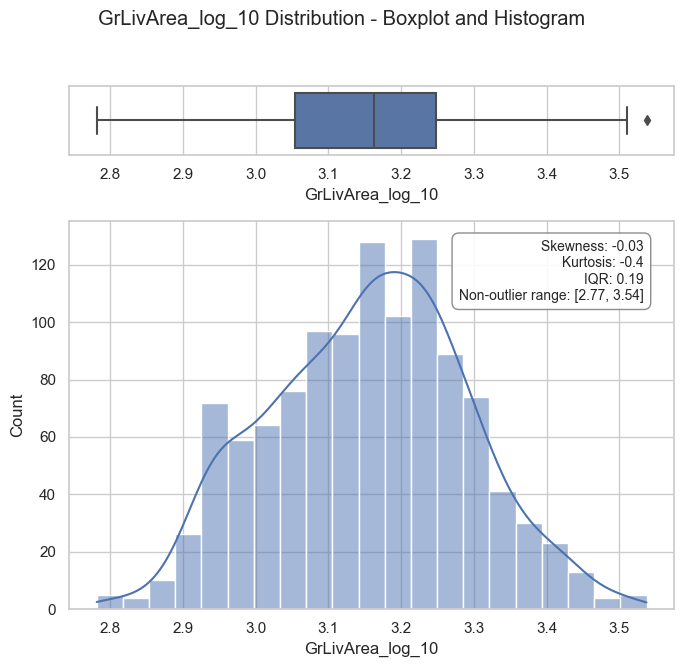

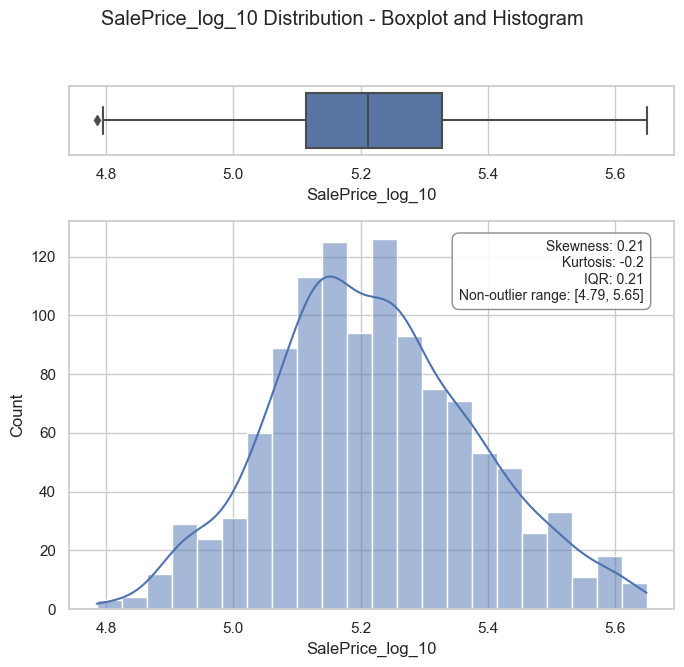

In [16]:
from feature_engine.outliers import OutlierTrimmer

outlier_trimmer = OutlierTrimmer(capping_method='iqr', tail='both', fold=1.5,
                                 variables=['GrLivArea_log_10', 'SalePrice_log_10'])
df_trimmed = outlier_trimmer.fit_transform(df)
plot_histogram_and_boxplot(df_trimmed[['GrLivArea_log_10', 'SalePrice_log_10']])

Let's try out using Winsorizer, how it looks

In [17]:
df_test = FeatureEngineeringAnalysis(df=df, analysis_type='outlier_winsorizer')

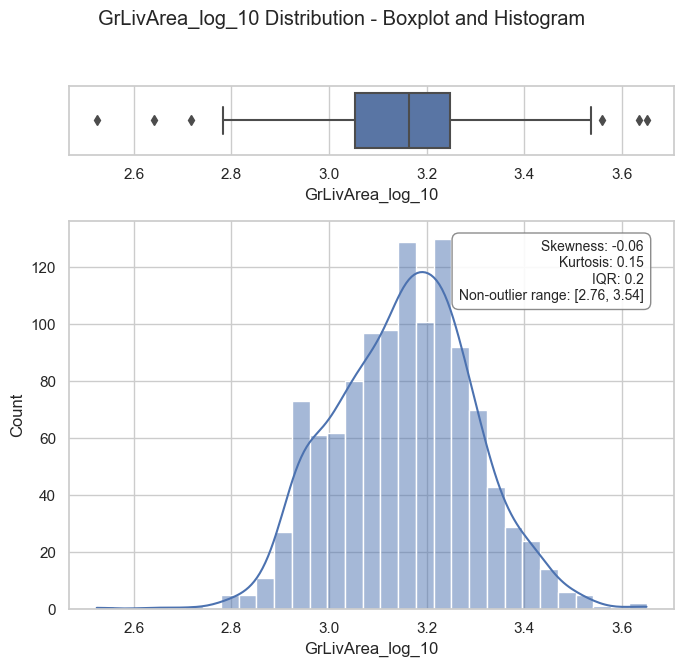

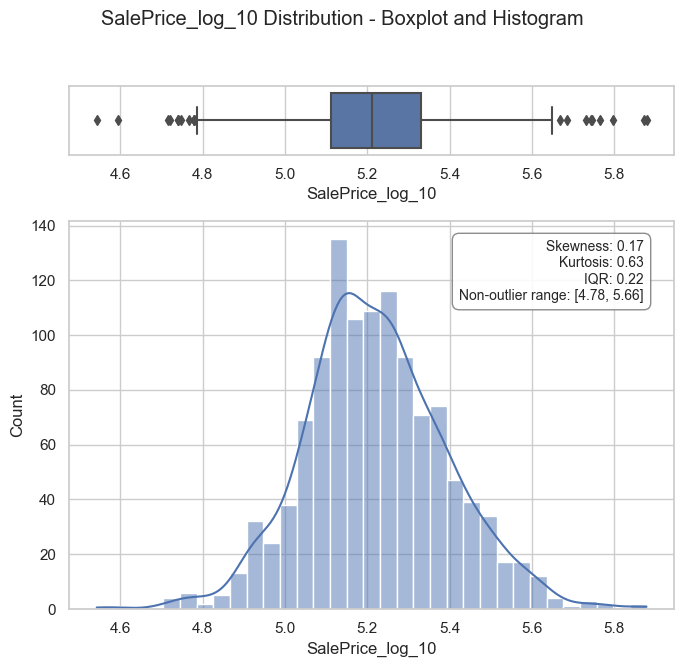

In [18]:
plot_histogram_and_boxplot(df[['GrLivArea_log_10', 'SalePrice_log_10']])


This looks way better. Now all we need now is to scale features:

## Conclusions

We will be applying following transformations:

### Yeo Johnson Transformation
- **1stFlrSF**: Test with removing outliers.
- **2ndFlrSF**
- **BedroomAbcGr**: Test with removing outliers.
- **BsmtExposure**
- **BsmtFinType1**
- **GarageFinish**
- **LotArea**: Has lots of outliers, test with removing them or discarding feature.
- **MasVnrArea**
- **OpenPorchSF**
- **OverallQual**: Test removing outliers.
- **TotalBsmtSF**: Test with scaling and removing outliers.

### Log Transformation
- **GarageYrBlt**: Apply Log_10.
- **GrLivArea**: Apply Log_10, needs removing outliers before creating model.
- **YearBuilt**: Apply Log_10.
- **YearRemodAdd**: Apply Log10
- **SalePrice**: Apply Log_10, remove outliers.

### Box Cox Transformation
- **LotFrontage**: Has lots of outliers, Might need discarding feature
- **OverallCond**: Test removing outliers.

### Power Transformation
- **BsmtFinSF1**: Test with scaling.
- **BsmtUnfSF**: Test with scaling, might need removing outliers.
- **KithenQual**: Has some negative values.

### Discard Features
- **EnclosedPorch**
- **WoodDeckSF**

### Other Tests and Operations
- **GarageArea**: Test with scaling and removing outliers.

